# Shelving to clock

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [49]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [50]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [51]:
def Rabi_clock(Fg, Fe, mg, me, d, pol):
    q = -(me-mg)
    Jg_d_Je = d
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus * CG_coeff
    )
    

In [52]:
wH = 0.025e-3
wV = wH
P = 0.6*80e-3
intensity = 2*P/np.pi/wV/wH
d = 4.5*hbar

In [53]:
Rabi_clock(1/2, 1/2, 1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.11223749592894952

In [54]:
Rabi_clock(1/2, 1/2, 1/2, 1/2, 4.5*hbar,  1)/1e6/2/np.pi

-0.07936389447475771

In [55]:
Rabi_clock(1/2, 1/2, -1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.07936389447475771

In [56]:
def cos_fit(t, f, phi):
    return -np.cos(2*np.pi*t*f+phi)*1/2+1/2

In [57]:
""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [58]:
_lambda = 578e-9
omega_r = 2*np.pi*9.4e3
m = 171*u
tau = 22

k = 2*np.pi/_lambda #momentum kick 
x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
LambDicke = x0*k #Lamb-Dicke parameters
print('Lamb-Dicke parameter (eta): ', LambDicke)
print('eta^2 (2n+1): ', LambDicke**2, '(2n+1)')
print('Max n for Lamb-Dicke regime: n = ', floor(((1/LambDicke**2)-1)/2))

Lamb-Dicke parameter (eta):  0.6095349993254959
eta^2 (2n+1):  0.3715329154027323 (2n+1)
Max n for Lamb-Dicke regime: n =  0


In [59]:
N=10 #keep HO states up to N 

one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
ground = fock(N, 0)

a = qutip.tensor(destroy(N), identity(4))
adag = qutip.tensor(create(N), identity(4))

sig_11 = qutip.tensor(identity(N),one*one.dag())
sig_22 = qutip.tensor(identity(N),two*two.dag())
sig_33 = qutip.tensor(identity(N),three*three.dag())
sig_44 = qutip.tensor(identity(N),four*four.dag())

sig_14 = qutip.tensor(identity(N),one*four.dag())
sig_41 = qutip.tensor(identity(N),four*one.dag())

sig_13 = qutip.tensor(identity(N),one*three.dag())
sig_31 = qutip.tensor(identity(N),three*one.dag())

sig_24 = qutip.tensor(identity(N),two*four.dag())
sig_42 = qutip.tensor(identity(N),four*two.dag())

sig_23 = qutip.tensor(identity(N),two*three.dag())
sig_32 = qutip.tensor(identity(N),three*two.dag())

# Contrast for shelveed qubit

# calibrate pi_time

In [60]:
psi0 = 1/np.sqrt(2)*(one+two)
psii = 1/np.sqrt(2)*(three-four)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [61]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.040900516094455636
ground state population 0.9607066040778716


In [62]:
B = 0e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 0.0 G


In [63]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [64]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [65]:
phi = 0
angle_pol = 0

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

 ) 

Hm = omega_r*(adag*a + 1/2)

Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)
                                      
     + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32) )

H = H0 + Hm + Hd

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output = mesolve(H, rho0, t_ls, c_ops, options=options, progress_bar=True)

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.1%. Run time:   0.00s. Est. time left: 00:00:00:00
30.1%. Run time:   0.00s. Est. time left: 00:00:00:00
40.1%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
70.0%. Run time:   0.02s. Est. time left: 00:00:00:00
80.0%. Run time:   0.02s. Est. time left: 00:00:00:00
90.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


In [66]:
rho_ls = output.states

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.993


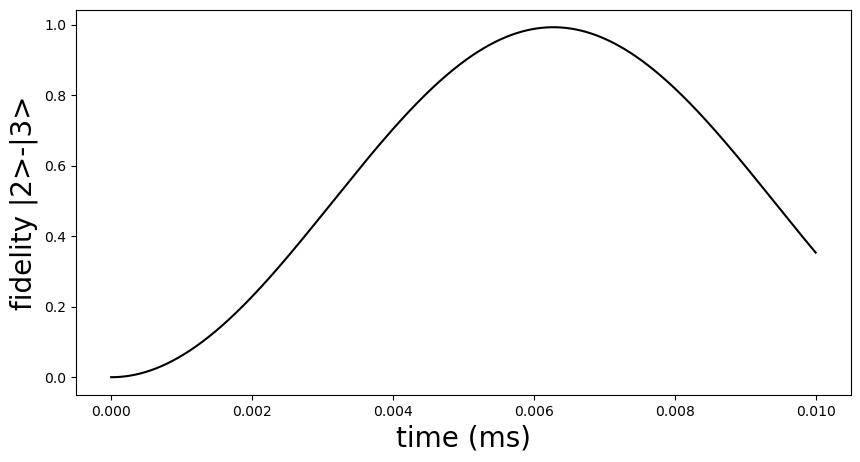

In [67]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, abs(np.array(P)), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'fidelity |2>-|3>', fontsize=20)
print('max fidelity: %.3f' %np.max(abs(np.array(P))))

pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx]

# run simulation

In [68]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)

rho0_ls = []
phase_ls = np.linspace(0, 2*np.pi, 100)
for phase in phase_ls:
    psi0 = 1/np.sqrt(2)*(one+np.exp(-1j*phase)*two)
    rho0_ls.append(qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag())) #start in up thermal state)

In [69]:
B = 0e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 0.0 G


In [70]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [71]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [72]:
def cos_fit(phase_ls, A, p0, y0):
    return A*1/2*(np.cos(phase_ls+p0))+y0

In [73]:
tpi_ls = np.arange(0, pi_time+dt, dt)
twait_ls = np.linspace(0.2e-3, .4e-3, 100)
twait_len=20

phi = 0
angle_pol = 0

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phi)*z)

#spherical tensor
pi_pol = x
sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

H0 = (
diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

 ) 

contrast_mean = []

for Ntraj in range(10):
    
    omega_temp = np.random.normal(loc=omega_r, scale=0.05*omega_r)
    k = 2*np.pi/_lambda #momentum kick 
    x0 = np.sqrt(hbar/2/m/omega_temp) #oscillator length
    LambDicke = x0*k #Lamb-Dicke parameters
    
    #print(omega_temp/2/np.pi/1e3)
    Hm = omega_temp*(adag*a + 1/2)

    Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                           offdiag_24*sig_24 + offdiag_23*sig_23)

         + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                            + offdiag_42*sig_42 + offdiag_32*sig_32) )

    H = H0 + Hm + Hd

    Hw = H0 + Hm

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    contrast_ls = []
    count=0

    for twait in twait_ls:
        output_ls = []
        for i, rho0 in enumerate(rho0_ls):
            output0 = mesolve(H, rho0, tpi_ls, c_ops, options=options)

            rho1 = output0.states[-1]

            output1 = mesolve(Hw, rho1, np.arange(pi_time, pi_time+twait+(twait)/twait_len, (twait)/twait_len), c_ops, options=options)

            rho2 = output1.states[-1]

            output2 = mesolve(H, rho2, tpi_ls, c_ops, options=options)

            output_ls.append(output2.states[-1])

        psii =  1/np.sqrt(2)*(one+two)
        rhoi = psii*psii.dag()
        i_proj = qutip.tensor(identity(N), rhoi)
        ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

        rho_ls = output_ls

        P = [(i_proj*rho).tr()  for rho in rho_ls]
        popt, pcov = curve_fit(cos_fit, phase_ls, abs(np.array(P)))
        contrast_ls.append(popt[0])
        
        if type(count%10)==int:
            print(count)
        count+=1
    
    contrast_mean.append(contrast_ls)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

Text(0, 0.5, 'contrast')

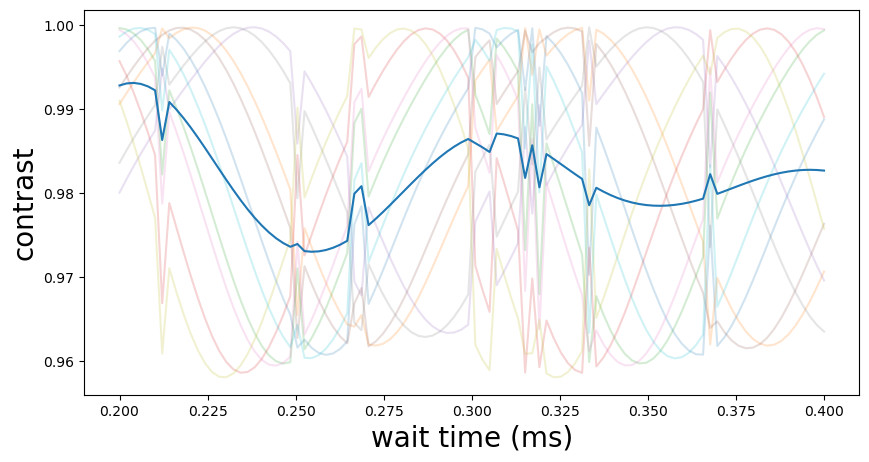

In [78]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
for idx in range(10):
    axes.plot(twait_ls*1e3, contrast_mean[idx], alpha=0.2)
axes.plot(twait_ls*1e3, np.mean(contrast_mean, axis=0))
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'contrast', fontsize=20)
#axes.set_ylim(0.999,1)

Text(0, 0.5, 'contrast')

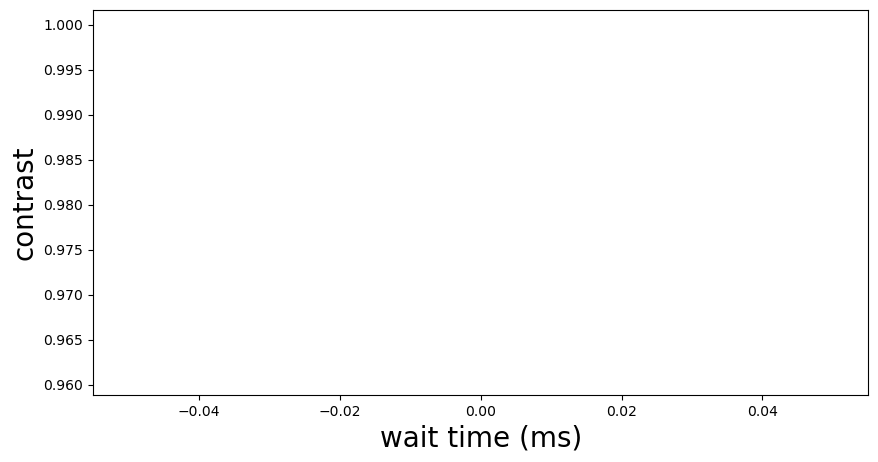

In [38]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(contrast_mean, linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'contrast', fontsize=20)

max fidelity: 0.988


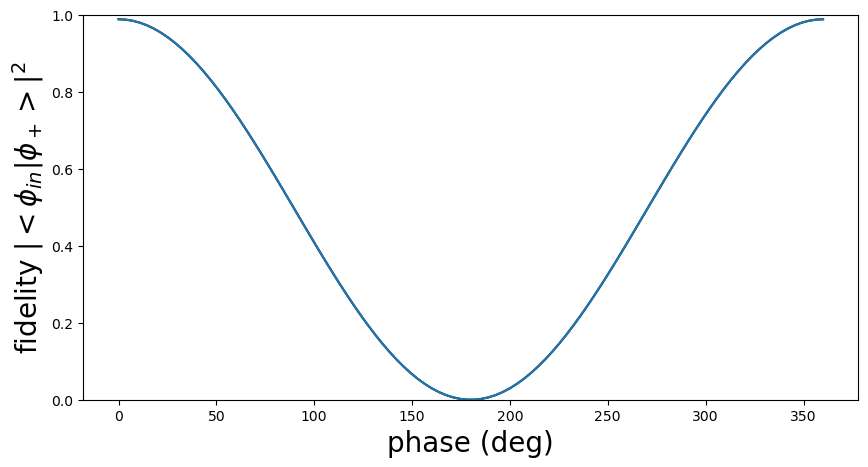

In [35]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(phase_ls*180/np.pi, abs(np.array(P)), color='k', linestyle='-', label = 'mF=-1/2')
axes.plot(phase_ls*180/np.pi, cos_fit(phase_ls, *popt))
axes.set_xlabel(r'phase (deg)', fontsize=20)
axes.set_ylabel(r'fidelity $|<\phi_{in}|\phi_+>|^2$', fontsize=20)
print('max fidelity: %.3f' %np.max(abs(np.array(P))))
plt.ylim(0, 1);

Text(0, 0.5, 'contrast')

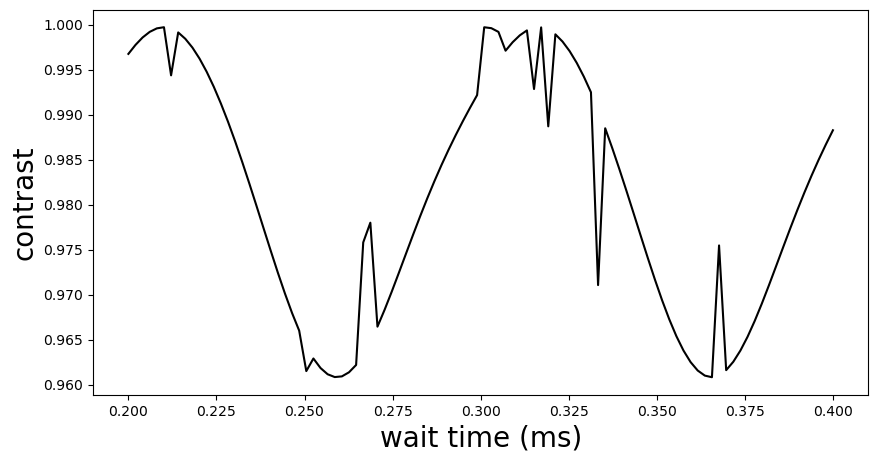

In [37]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(twait_ls*1e3, contrast_ls, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'contrast', fontsize=20)
#axes.set_ylim(0.999,1)